In [1]:
# Fine tuning classificatin with OpenAI

We will fine-tune some OpenAI classifier to classify the number of stars a reviewer will give a review of an app

In [2]:
# Importing necessaruy libraries
import pandas as pd
from openai import OpenAI
import os
from datasets import load_dataset
import random
import math
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import base64
import csv
import time

# Setting the style to a modern look
sns.set_style('whitegrid')

# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure condidtent results
random.seed(SEED)


%matplotlib inline

In [ ]:
os.environ["OPENAI_API_KEY"] = ""

In [4]:
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# Importing the ClassLabel module to represint categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column into our dataset to a ClassLabel type
# this allows for categorical represetation and easier handling or classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [5]:
dataset[0]

{'package_name': 'com.mantz_it.rfanalyzer',
 'review': "Great app! The new version now works on my Bravia Android TV which is great as it's right by my rooftop aerial cable. The scan feature would be useful...any ETA on when this will be available? Also the option to import a list of bookmarks e.g. from a simple properties file would be useful.",
 'date': 'October 12 2016',
 'star': 3}

In [6]:
dataset = dataset.train_test_split(test_size=.2, seed=SEED, stratify_by_column='star')

df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

dataset['train'] = df['train']

dataset['val'] = df['test']

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [8]:
# convert to pandas dataframe
training_df = pd.DataFrame(dataset['train'])

training_df[['review', 'star']].head(10)

,review,star
0,Nice😉,4
1,Google play service Just one ward its amazing ...,4
2,Mr Perfect,0
3,Does not work with Tmobile S4 If you try to in...,0
4,Ok,2
5,Say App Ka nam to the other than a few months,4
6,Owk,4
7,Coc,4
8,Not working bad,0
9,After downloading this app my phone slowed do...,0


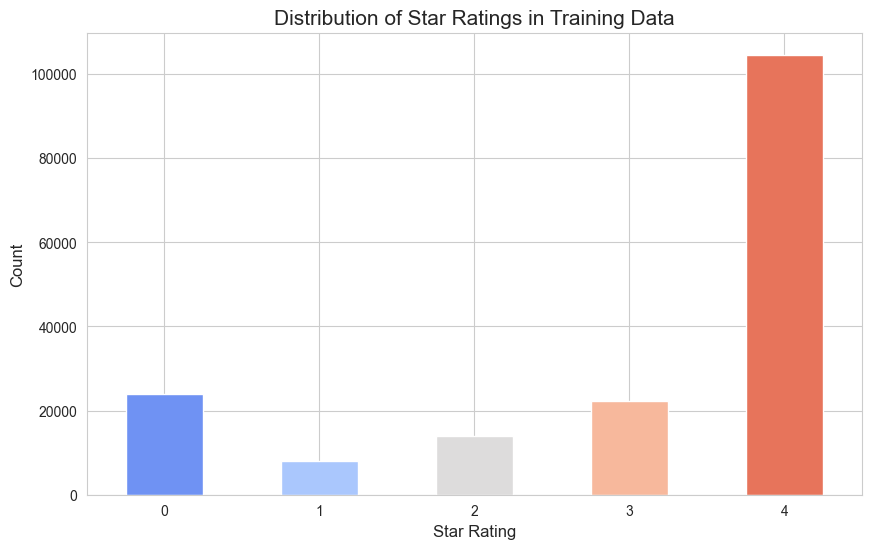

In [9]:
# Counting the number of orrrurences for each 'star' value, sorting by index
star_counts = training_df['star'].value_counts().sort_index()

# Creating the bar plot to show distributino of star tatings given
plt.figure(figsize=(10, 6))

star_counts.plot(kind='bar', color=sns.color_palette('coolwarm', len(star_counts)))


# Adding titles and labels for clarity
plt.title('Distribution of Star Ratings in Training Data', fontsize=15)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.show();

In [10]:
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['val'])

# Star prediction (sentiment)

In [11]:
training_df['prompt'] = training_df['review'] + '\n###\n'
val_df['prompt'] = val_df['review'] + '\n###\n'
test_df['prompt'] = test_df['review'] + '\n###\n'

# Converting the 'star' column in esch dataset to a string format and storing it in the 'completion' column.
# The 'completion' column will be used as the target variable for sentiment analysis.
training_df['completion'] = training_df['star'].astype(str)
val_df['completion'] = val_df['star'].astype(str)
test_df['completion'] = test_df['star'].astype(str)

training_df.sample(
    len(training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-train-sentiment-random.jsonl", orient='records', lines=True
)

val_df.sample(
    len(val_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-val-sentiment-random.jsonl", orient='records', lines=True
)

# Creating a validation dataset in JSONL format after dropping duplicates based on the 'prompt' column.
test_df.sample(
    len(test_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-val-sentiment-random.jsonl", orient='records', lines=True
)

In [12]:
training_df.head(2)

,package_name,review,date,star,prompt,completion
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4,Nice😉\n###\n,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4,Google play service Just one ward its amazing ...,4


In [13]:
def get_data_dict(row, system=''):
    return {
        "messages": [
            # {"role": "system", "content": system},
            {"role": "system", "content": ''},
            {"role": "user", "content": row['review']},
            {"role": "assistant", "content": str(row['star'])}
        ]
    }

# export 3.5 prompt with no system prompt
with open(f'app-review-full-train-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in training_df.iterrows():
        json_str = json.dumps(get_data_dict(row)) # Create dictionary for each row
        f.write(json_str + '\n') # Write JSON string to a file

with open(f'app-review-full-test-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in test_df.iterrows():
        json_str = json.dumps(get_data_dict(row)) # Create dictionary for each row
        f.write(json_str + '\n') # Write JSON string to a file

with open(f'app-review-full-val-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in val_df.iterrows():
        json_str = json.dumps(get_data_dict(row)) # Create dictionary for each row
        f.write(json_str + '\n') # Write JSON string to a file    

In [14]:
system_prompt = 'You predict star ratings from 0-4 where 0 is the worst rating and 4 in the best'

In [15]:
# export  3.5 prompts with a system prompt
# 22 extra tokens PER sample
with open(f'app-review-full-train-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in training_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt)) # Create dictionary for each row
        f.write(json_str + '\n') # Write JSON string to a file

with open(f'app-review-full-test-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in test_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt)) # Create dictionary for each row
        f.write(json_str + '\n') # Write JSON string to a file

with open(f'app-review-full-val-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in val_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt)) # Create dictionary for each row
        f.write(json_str + '\n') # Write JSON string to a file   

In [16]:
print(training_df['prompt'].iloc[0])

Nice😉
###



In [17]:
training_df['star'].iloc[0]

np.int64(4)

# Using OpenAI's Fine-tuning API

In [18]:
# reminder of what this data looks like
json.loads(open('app-review-full-train-sentiment-random-3.5.jsonl', 'rb').readlines()[0])

{'messages': [{'role': 'system', 'content': ''},
  {'role': 'user', 'content': 'Nice😉'},
  {'role': 'assistant', 'content': '4'}]}

In [19]:
# Creating a file object for the training dataset with OpenAI's API.
# The 'file' parameter specifies the path to the training data in JSONL format.
# The 'purpose' is set to 'fine-rune', indicating the file's intended use.
no_system_training_file = client.files.create(
    file=open('app-review-full-train-sentiment-random-3.5.jsonl', 'rb'),
    purpose='fine-tune'
)

# Creating a file object for the validation dataset with OpenAI's API

no_system_val_file = client.files.create(
    file=open('app-review-full-val-sentiment-random-3.5.jsonl', 'rb'),
    purpose='fine-tune'
)

In [20]:
no_system_training_file

FileObject(id='file-2SFVrYEZpBAnRXRygTNMy9', bytes=32291249, created_at=1758896392, filename='app-review-full-train-sentiment-random-3.5.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [21]:
# Initiating the fine-runing process with OpenAI's API.
# The `client.fine_tuning.jobs.create` method is used to start the training.
# Parameters include:
# - `training_file`: The ID of the previously uploaded training dataset file.
# - `validation_file`: The IS of the previously uploaded validation dataset file.
# - `model`: The base model to be fine-runed. In this case, "babbage-002" is chosen.
# - `hyperparameters`: Dictionary containing training hyperparameters. Here, we specify the number of epochs as 1.
no_system_babbage_job = client.fine_tuning.jobs.create(
    training_file=no_system_training_file.id,
    validation_file=no_system_val_file.id,
    model="gpt-3.5-turbo", # the babbage-002 mode doesn't exists now
    hyperparameters={'n_epochs': 1}
)

In [22]:
# Retriving details of an ongoing or completed fine-runing job using OpenAi's API.
job = client.fine_tuning.jobs.retrieve(no_system_babbage_job.id)

In [23]:
job

FineTuningJob(id='ftjob-I8o7f3fxaclrUDex75T5Euu1', created_at=1758896399, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-pGUz4fiqvCKviYv0vpEAwckT', result_files=[], seed=727477345, status='validating_files', trained_tokens=None, training_file='file-2SFVrYEZpBAnRXRygTNMy9', validation_file='file-82xXMwko3vC7MKZVq515Tj', estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)

In [24]:
job.id

'ftjob-I8o7f3fxaclrUDex75T5Euu1'

In [26]:
results_df = None

if len(job.result_files):
    print(job.result_files)
    results = client.files.content(job.result_files[0])


# # Base64 string (example, replace with your actual string)
base64_string = results.read()

# Decode the base64 string
decoded_bytes = base64.b64decode(base64_string)
decoded_str = decoded_bytes.decode('utf-8')

NameError: name 'results' is not defined

In [ ]:
job.result_files[0]

In [ ]:
job.result_files

In [ ]:
# Assuming the content is in CSV format, you can write it to a CSV file directly
with open('results.csv', 'w') as file:
    file.write(decoded_str)

print("CSV file created successfully.")

results_df = pd.read_csv('results.csv')

results_df.head()

In [ ]:
# Plotting the 'valid_loss' values from the 'results_df' DataFrame.
# We drop any NaN values to ensure a smooth plot.
plt.figure(figsize=(10, 6))
results_df['train_loss'].dropna().plot(color='royalblue')

# Adding titles and labels for clarity
plt.title('Training Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)

# Displaying the plot
plt.savefig('2.png', dpi=500)
plt.show()

In [ ]:
# Plotting the 'valid_mean_token_accuracy' values from the 'results_df' DataFrame.
# We omit any NaN values to ensure a smoooth, continuous plot.
# Adding titles and labels for clarity
plt.figure(figsize=(10, 6))
results_df['train_accuracy'].dropna().plot(color='darkgreen')

plt.title('Training Acuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

# Displaying the plot
plt.savefig('1.png', dpi=500)
plt.show()